In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import copy
import os

import sys
import time
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.mlab as mlab
from helper import df_to_latex, fig_path, set_figsize, tab_path

# Import code from src
sys.path.insert(0, '../src/')
import vmc


# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

fontsize = "large"

params = {"font.family": "serif",
          "font.sans-serif": ["Computer Modern"],
          "axes.labelsize": fontsize,
          "legend.fontsize": fontsize,
          "xtick.labelsize": fontsize,
          "ytick.labelsize": fontsize,
          "legend.handlelength": 2
          }


plt.rcParams.update(params)
plt.rc('text', usetex=True)

"""
# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

# Set fontsizes in figures
fontsize = 10
tex_fonts = {
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern"],
    "axes.labelsize": fontsize,
    "font.size": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize-1,
    "ytick.labelsize": fontsize-1,
    'legend.handlelength': 2
}

plt.rcParams.update(tex_fonts)
"""
# Set figure size
width = 410 #360
figsize = set_figsize(width, fraction=1)

In [2]:
def exact_energy(N, dim, omega):
    return (omega * dim * N) / 2

def safe_initial_positions_no_interactions(wavefunction, alpha, N, dim, seed=None):
    rng = np.random.default_rng(seed=seed)
    positions = rng.random(size=(N, dim))

    # safe initialization
    wf2 = wavefunction.pdf(positions, alpha)
    while np.sum(wf2) <= 1e-14:
        positions *= 0.5
        wf2 = wavefunction.pdf(positions, alpha)

    return positions

def safe_initial_positions_w_interactions(wavefunction, alpha, N, dim, seed=None): 
    rng = np.random.default_rng(seed=seed)
    positions = rng.random(size=(N, dim))
    
    # safe initialization
    wf2 = wavefunction.pdf(positions, alpha)
    while np.sum(wf2) <= 1e-14: 
        positions *= 2.0
        wf2 = wavefunction.pdf(positions, alpha)
        
    return positions

def interact_initial_positions(wf, alpha, N, dim, a=0.00433):

    rng = np.random.default_rng()

    def corr_factor(r1, r2):
        rij = np.linalg.norm(r1 - r2)
        if rij <= a:
            return 0.
        else:
            return 1 - (a / rij)

    scale = 2.
    r = np.random.randn(N, dim) * scale
    #r = rng.random(size=(N, dim))

    rerun = True
    while rerun:
        rerun = False
        for i in range(N):
            for j in range(i + 1, N):
                corr = corr_factor(r[i, :], r[j, :])
                if corr == 0.:
                    print("corr=0 encountered")
                    rerun = True
                    r[i, :] = np.random.randn() * scale
                    r[j, :] = np.random.randn() * scale
        scale *= 1.5

    return r, scale

def get_mean_w_standard_error_grid_search(data, alphas): 
    data_dict = {"alpha": alphas, "mean_energy": [], "standard_error_of_the_mean": []}
    for i, alpha in enumerate(alphas): 
        energies_alpha = data["energy"][data["alpha"]==alpha]
        standard_errors_alpha = data["standard_error"][data["alpha"]==alpha]
        mean_energy_alpha = np.mean(energies_alpha)
        standard_error_of_the_mean = np.std(standard_errors_alpha)/np.sqrt(len(standard_errors_alpha))
        data_dict["mean_energy"].append(mean_energy_alpha)
        data_dict["standard_error_of_the_mean"].append(standard_error_of_the_mean)
        
    dataframe = pd.DataFrame(data=data_dict)
    return dataframe

Sampler elapsed time: 69.27778673171997
      r       pdf
0   0.0  0.507092
1   0.1  0.487983
2   0.2  0.488442
3   0.3  0.465468
4   0.4  0.438329
5   0.5  0.398865
6   0.6  0.349627
7   0.7  0.308330
8   0.8  0.268608
9   0.9  0.222630
10  1.0  0.188291
11  1.1  0.152140
12  1.2  0.120240
13  1.3  0.092595
14  1.4  0.070838
15  1.5  0.052703
16  1.6  0.038330
17  1.7  0.028519
18  1.8  0.019672
19  1.9  0.013658
20  2.0  0.009245
Sampler elapsed time: 141.26658606529236
      r       pdf
0   0.0  0.496470
1   0.1  0.483816
2   0.2  0.476941
3   0.3  0.453698
4   0.4  0.420889
5   0.5  0.383654
6   0.6  0.344811
7   0.7  0.305375
8   0.8  0.260979
9   0.9  0.224548
10  1.0  0.182998
11  1.1  0.151147
12  1.2  0.118673
13  1.3  0.092777
14  1.4  0.071021
15  1.5  0.052933
16  1.6  0.038840
17  1.7  0.028418
18  1.8  0.019959
19  1.9  0.013624
20  2.0  0.009204


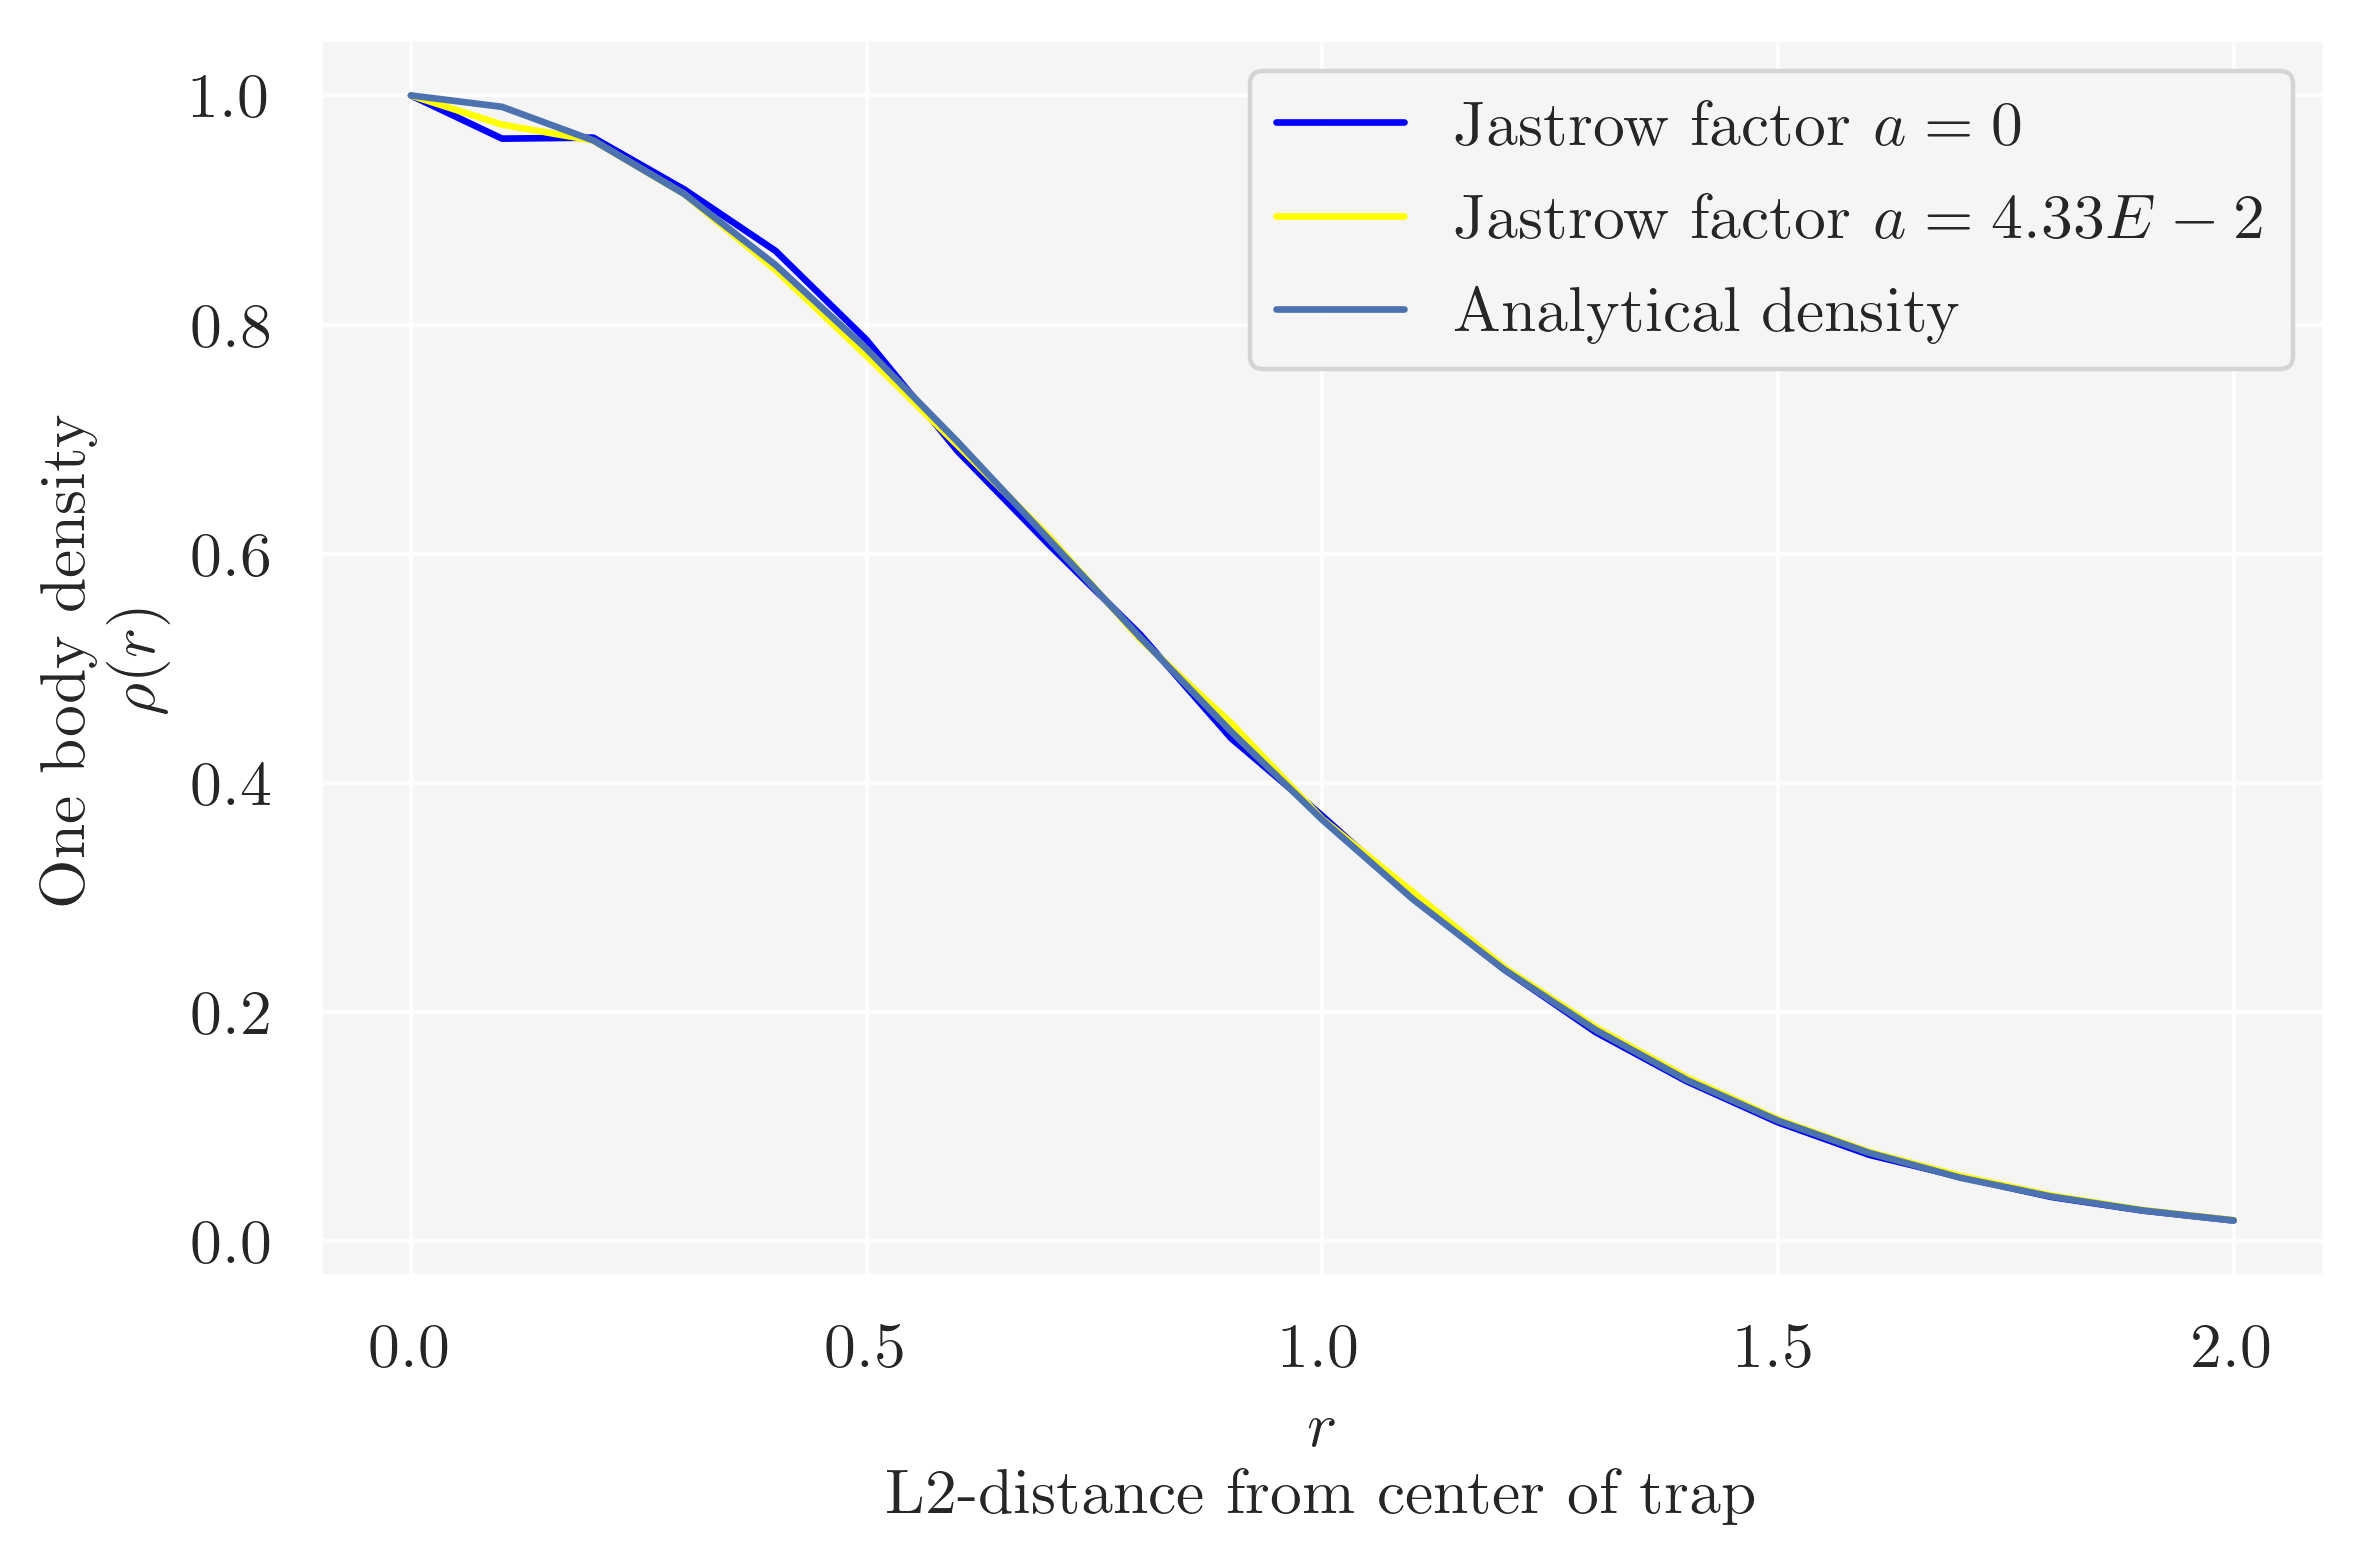

In [10]:
N = 2 # Number of particles
dim = 2     # Dimensionality
omega = 1.   # Oscillator frequency

# Config

nsamples = 25000
alpha = 0.5

x = np.linspace(0,2,21)/np.sqrt(2)
#y = np.linspace(0,1,11)
#mx, my = np.meshgrid(x, y, indexing="ij")
# NON-INTERACTING
wf = vmc.ASHONIB(N, dim, omega)
#wf = vmc.SHONIB(omega)
# wf = vmc.EHONIB()
#initial_positions = non_interact_initial_positions(wf, initial_alpha, N, dim)

# INTERACTING
#wf = vmc.SHOIB(N, dim, omega)

#wf = vmc.ASHOIB(N, dim, omega)
#wf = vmc.EHOIB()




#wf = vmc.EHOIB()

initial_positions, scale = interact_initial_positions(wf,
                                                      alpha,
                                                      N,
                                                      dim)

# Instantiate sampler
sampler = vmc.OBDMetropolis(wf)
#sampler = vmc.MetropolisHastings(wf)

num_chains = 1
results = {"r": [], "pdf": []}
start = time.time()
for i in range(len(x)):
    if (i==0):
        x_ = x[i]
        results["r"].append(np.sqrt(2*x_**2))
        particle = np.array([x_, x_])
        state, pdf = sampler.sample(particle,
                                    nsamples,
                                    initial_positions,
                                    alpha,
                                    scale=1.0,  # METROPOLIS
                                    nchains=num_chains,
                                    warm=True,
                                    warmup_iter=100000,
                                    tune=True,
                                    tune_iter=10000,                                        
                                    tune_interval=500
                                    )
        results["pdf"].append(pdf)

    else:
        x_ = x[i]
        results["r"].append(np.sqrt(2*x_**2))
        particle = np.array([x_, x_])
        positions, pdf = sampler.sample(particle,
                                        nsamples,
                                        state.positions,
                                        alpha,
                                        scale=1.0,
                                        nchains=num_chains,
                                        warm=True,
                                        warmup_iter=1000,
                                        tune=False,
                                        )
        results["pdf"].append(pdf)

end = time.time()
print("Sampler elapsed time:", end - start)
df_non_interacting = pd.DataFrame(data=results)
print(df_non_interacting)

wf = vmc.ASHOIB(N, dim, omega, a=0.00433)
#wf = vmc.EHOIB()




#wf = vmc.EHOIB()

initial_positions, scale = interact_initial_positions(wf,
                                                      alpha,
                                                      N,
                                                      dim)

# Instantiate sampler
sampler = vmc.OBDMetropolis(wf)
#sampler = vmc.MetropolisHastings(wf)

num_chains = 1
results = {"r": [], "pdf": []}
start = time.time()
for i in range(len(x)):
    if (i==0):
        x_ = x[i]
        results["r"].append(np.sqrt(2*x_**2))
        particle = np.array([x_, x_])
        state, pdf = sampler.sample(particle,
                                    nsamples,
                                    initial_positions,
                                    alpha,
                                    scale=1.0,  # METROPOLIS
                                    nchains=num_chains,
                                    warm=True,
                                    warmup_iter=10000,
                                    tune=True,
                                    tune_iter=10000,                                        
                                    tune_interval=500
                                    )
        results["pdf"].append(pdf)

    else:
        x_ = x[i]
        results["r"].append(np.sqrt(2*x_**2))
        particle = np.array([x_, x_])
        positions, pdf = sampler.sample(particle,
                                        nsamples,
                                        state.positions,
                                        alpha,
                                        scale=1.0,
                                        nchains=num_chains,
                                        warm=True,
                                        warmup_iter=1000,
                                        tune=False,
                                        )
        results["pdf"].append(pdf)

end = time.time()
print("Sampler elapsed time:", end - start)
dfN10 = pd.DataFrame(data=results)
print(dfN10)
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True, dpi=200)
df_non_interacting["pdf"] = df_non_interacting["pdf"]/max(df_non_interacting["pdf"])
dfN10["pdf"] = dfN10["pdf"]/max(dfN10["pdf"])
sns.lineplot(data=df_non_interacting, x="r", y="pdf", ax=ax, color="blue", label='Jastrow factor $a=0$')
sns.lineplot(data=dfN10, x="r", y="pdf", ax=ax, color="yellow", label=r'Jastrow factor $a=4.33E-2$')
plt.plot(dfN10["r"], np.exp(-dfN10["r"]**2), label="Analytical density")
tex_xlabel = '\n'.join((r'$r$',
                      'L2-distance from center of trap'))
tex_ylabel =  '\n'.join(('One body density',
                         r'$\rho(r)$'))
ax.set_xticks([0, 0.5, 1.0, 1.5, 2.0])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.grid(True, color="white", alpha=0.9)
ax.set(xlabel=tex_xlabel, ylabel=tex_ylabel)
ax.legend()
plt.show()

fig.savefig(fig_path("obd.pdf"), bbox_inches='tight')

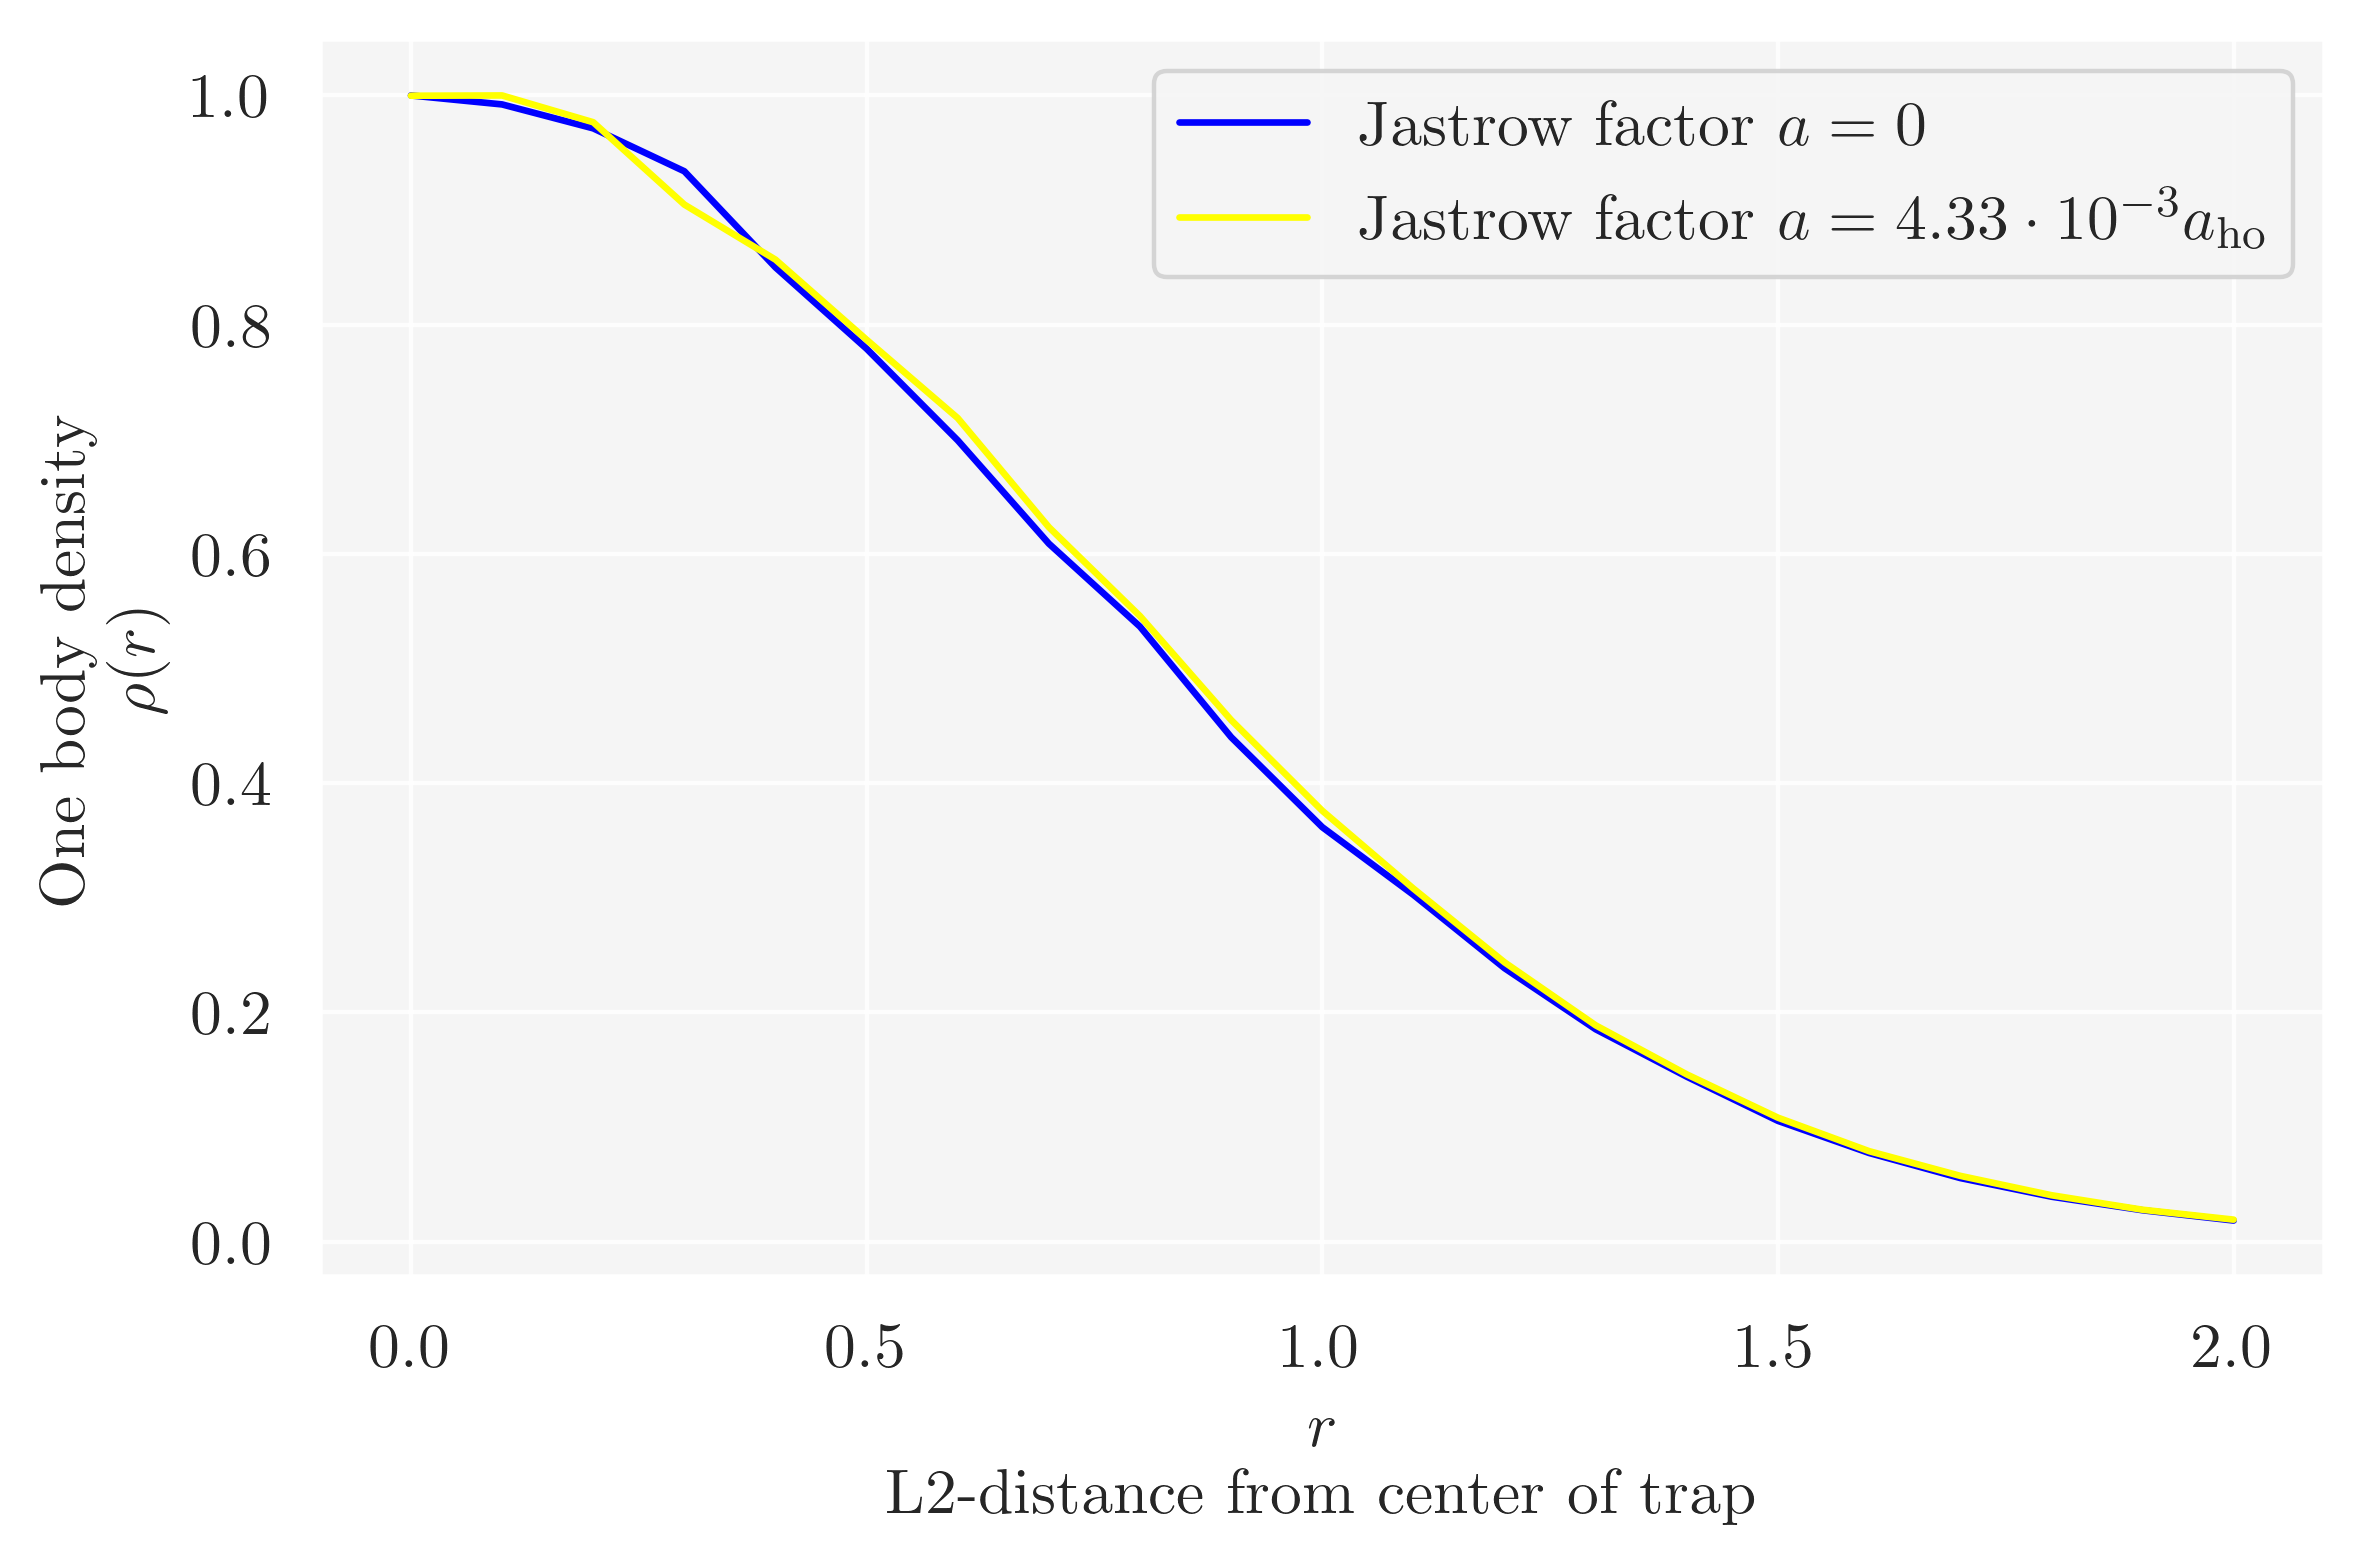

In [9]:
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True, dpi=200)
df_non_interacting["pdf"] = df_non_interacting["pdf"]/max(df_non_interacting["pdf"])
dfN10["pdf"] = dfN10["pdf"]/max(dfN10["pdf"])
sns.lineplot(data=df_non_interacting, x="r", y="pdf", ax=ax, color="blue", label='Jastrow factor $a=0$')
sns.lineplot(data=dfN10, x="r", y="pdf", ax=ax, color="yellow", label=r'Jastrow factor $a=4.33\cdot 10^{-3}a_{\mathrm{ho}}$')
#plt.plot(dfN10["r"], np.exp(-dfN10["r"]), label="Analytical density")
tex_xlabel = '\n'.join((r'$r$',
                      'L2-distance from center of trap'))
tex_ylabel =  '\n'.join(('One body density',
                         r'$\rho(r)$'))
ax.set_xticks([0, 0.5, 1.0, 1.5, 2.0])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.grid(True, color="white", alpha=0.9)
ax.set(xlabel=tex_xlabel, ylabel=tex_ylabel)
ax.legend()
plt.show()

fig.savefig(fig_path("obd.pdf"), bbox_inches='tight')

In [ ]:
# wf = vmc.ASHONIB(N, dim, omega)
#wf = vmc.SHONIB(omega)
# wf = vmc.EHONIB()
#initial_positions = non_interact_initial_positions(wf, initial_alpha, N, dim)
N = 2
# INTERACTING
#wf = vmc.SHOIB(N, dim, omega)

wf = vmc.ASHOIB(N, dim, omega)
#wf = vmc.EHOIB()




#wf = vmc.EHOIB()

initial_positions, scale = interact_initial_positions(wf,
                                                      initial_alpha,
                                                      N,
                                                      dim)

# Instantiate sampler
sampler = vmc.OBDMetropolis(wf)
#sampler = vmc.MetropolisHastings(wf)

num_chains = 1
results = {"r": [], "pdf": []}
start = time.time()
for i in range(21):
    x_ = x[i]
    results["r"].append(np.sqrt(x_**2 + x_**2))
    particle = np.array([x_, x_])
    if (i==0):
        state, pdf = sampler.sample(particle,
                                    nsamples,
                                    initial_positions,
                                    initial_alpha,
                                    scale=1.0,  # METROPOLIS
                                    nchains=num_chains,
                                    warm=True,
                                    warmup_iter=10000,
                                    tune=True,
                                    tune_iter=10000,                                        
                                    tune_interval=500
                                    )
        results["pdf"].append(pdf)

    else:
        positions, pdf = sampler.sample(particle,
                                        nsamples,
                                        state.positions,
                                        initial_alpha,
                                        scale=1.0,
                                        nchains=num_chains,
                                        warm=True,
                                        warmup_iter=1000,
                                        tune=False,
                                        )
        results["pdf"].append(pdf)

end = time.time()
print("Sampler elapsed time:", end - start)
dfN10 = pd.DataFrame(data=results)
print(dfN10)

fig, ax = plt.subplots(figsize=(6,4), tight_layout=True, dpi=200)
df_non_interacting["pdf"] = df_non_interacting["pdf"]/max(df_non_interacting["pdf"])
modfN10["pdf"] = modfN10["pdf"]/max(df_non_interacting["pdf"])
sns.lineplot(data=modf_non_interacting, x="r", y="pdf", ax=ax, color="blue", label='No interactions, N=2')
sns.lineplot(data=modfN10, x="r", y="pdf", ax=ax, color="yellow", label=r'Interactions, N=2')
tex_xlabel = '\n'.join((r'$r = \sqrt{x^2 + y^2}$ in ($a_ho$)',
                      'L2-distance from center of trap'))
tex_ylabel = '\n'.join(('One body density',
                        r'$\rho(r)$'))
ax.set(xlabel=tex_xlabel, ylabel=tex_ylabel)
ax.legend()
plt.show()

fig.savefig(fig_path("obd_all.pdf"), bbox_inches='tight')

In [16]:
#wf = vmc.ASHONIB(N, dim, omega)
#wf = vmc.SHONIB(omega)
# wf = vmc.EHONIB()
#initial_positions = non_interact_initial_positions(wf, initial_alpha, N, dim)
N = 50
# INTERACTING
#wf = vmc.SHOIB(N, dim, omega)

wf = vmc.ASHOIB(N, dim, omega)
#wf = vmc.EHOIB()




#wf = vmc.EHOIB()

initial_positions, scale = interact_initial_positions(wf,
                                                      initial_alpha,
                                                      N,
                                                      dim)

# Instantiate sampler
sampler = vmc.OBDMetropolis(wf)
#sampler = vmc.MetropolisHastings(wf)

num_chains = 1
results = {"r": [], "pdf": []}
start = time.time()
for i in range(11):
    x_ = x[i]
    results["r"].append(np.sqrt(x_**2 + x_**2))
    particle = np.array([x_, x_])
    if (i==0):
        state, pdf = sampler.sample(particle,
                                    nsamples,
                                    initial_positions,
                                    initial_alpha,
                                    scale=1.0,  # METROPOLIS
                                    nchains=num_chains,
                                    warm=True,
                                    warmup_iter=5000,
                                    tune=True,
                                    tune_iter=10000,                                        
                                    tune_interval=500
                                    )
        results["pdf"].append(pdf)

    else:
        positions, pdf = sampler.sample(particle,
                                        nsamples,
                                        state.positions,
                                        initial_alpha,
                                        scale=1.0,
                                        nchains=num_chains,
                                        warm=True,
                                        warmup_iter=100,
                                        tune=False,
                                        )
        results["pdf"].append(pdf)

end = time.time()
print("Sampler elapsed time:", end - start)
dfN50 = pd.DataFrame(data=results)
print(dfN50)

Sampler elapsed time: 74.49511885643005
      r           pdf
0   0.0  5.402692e-21
1   0.2  3.767462e-39
2   0.4  3.767462e-39
3   0.6  3.767462e-39
4   0.8  3.767462e-39
5   1.0  3.767462e-39
6   1.2  3.767462e-39
7   1.4  3.767462e-39
8   1.6  3.767462e-39
9   1.8  3.767462e-39
10  2.0  3.767462e-39


In [17]:
#wf = vmc.ASHONIB(N, dim, omega)
#wf = vmc.SHONIB(omega)
# wf = vmc.EHONIB()
#initial_positions = non_interact_initial_positions(wf, initial_alpha, N, dim)
N = 100
# INTERACTING
#wf = vmc.SHOIB(N, dim, omega)

wf = vmc.ASHOIB(N, dim, omega)
#wf = vmc.EHOIB()




#wf = vmc.EHOIB()

initial_positions, scale = interact_initial_positions(wf,
                                                      initial_alpha,
                                                      N,
                                                      dim)

# Instantiate sampler
sampler = vmc.OBDMetropolis(wf)
#sampler = vmc.MetropolisHastings(wf)

num_chains = 1
results = {"r": [], "pdf": []}
start = time.time()
for i in range(11):
    x_ = x[i]
    results["r"].append(np.sqrt(x_**2 + x_**2))
    particle = np.array([x_, x_])
    if (i==0):
        state, pdf = sampler.sample(particle,
                                    nsamples,
                                    initial_positions,
                                    initial_alpha,
                                    scale=1.0,  # METROPOLIS
                                    nchains=num_chains,
                                    warm=True,
                                    warmup_iter=5000,
                                    tune=True,
                                    tune_iter=10000,                                        
                                    tune_interval=500
                                    )
        results["pdf"].append(pdf)

    else:
        positions, pdf = sampler.sample(particle,
                                        nsamples,
                                        state.positions,
                                        initial_alpha,
                                        scale=1.0,
                                        nchains=num_chains,
                                        warm=True,
                                        warmup_iter=100,
                                        tune=False,
                                        )
        results["pdf"].append(pdf)

end = time.time()
print("Sampler elapsed time:", end - start)
dfN100 = pd.DataFrame(data=results)
print(dfN100)

Sampler elapsed time: 182.47549104690552
      r           pdf
0   0.0  1.940736e-58
1   0.2  5.899981e-57
2   0.4  5.899981e-57
3   0.6  5.899981e-57
4   0.8  5.899981e-57
5   1.0  5.899981e-57
6   1.2  5.899981e-57
7   1.4  5.899981e-57
8   1.6  5.899981e-57
9   1.8  5.899981e-57
10  2.0  5.899981e-57


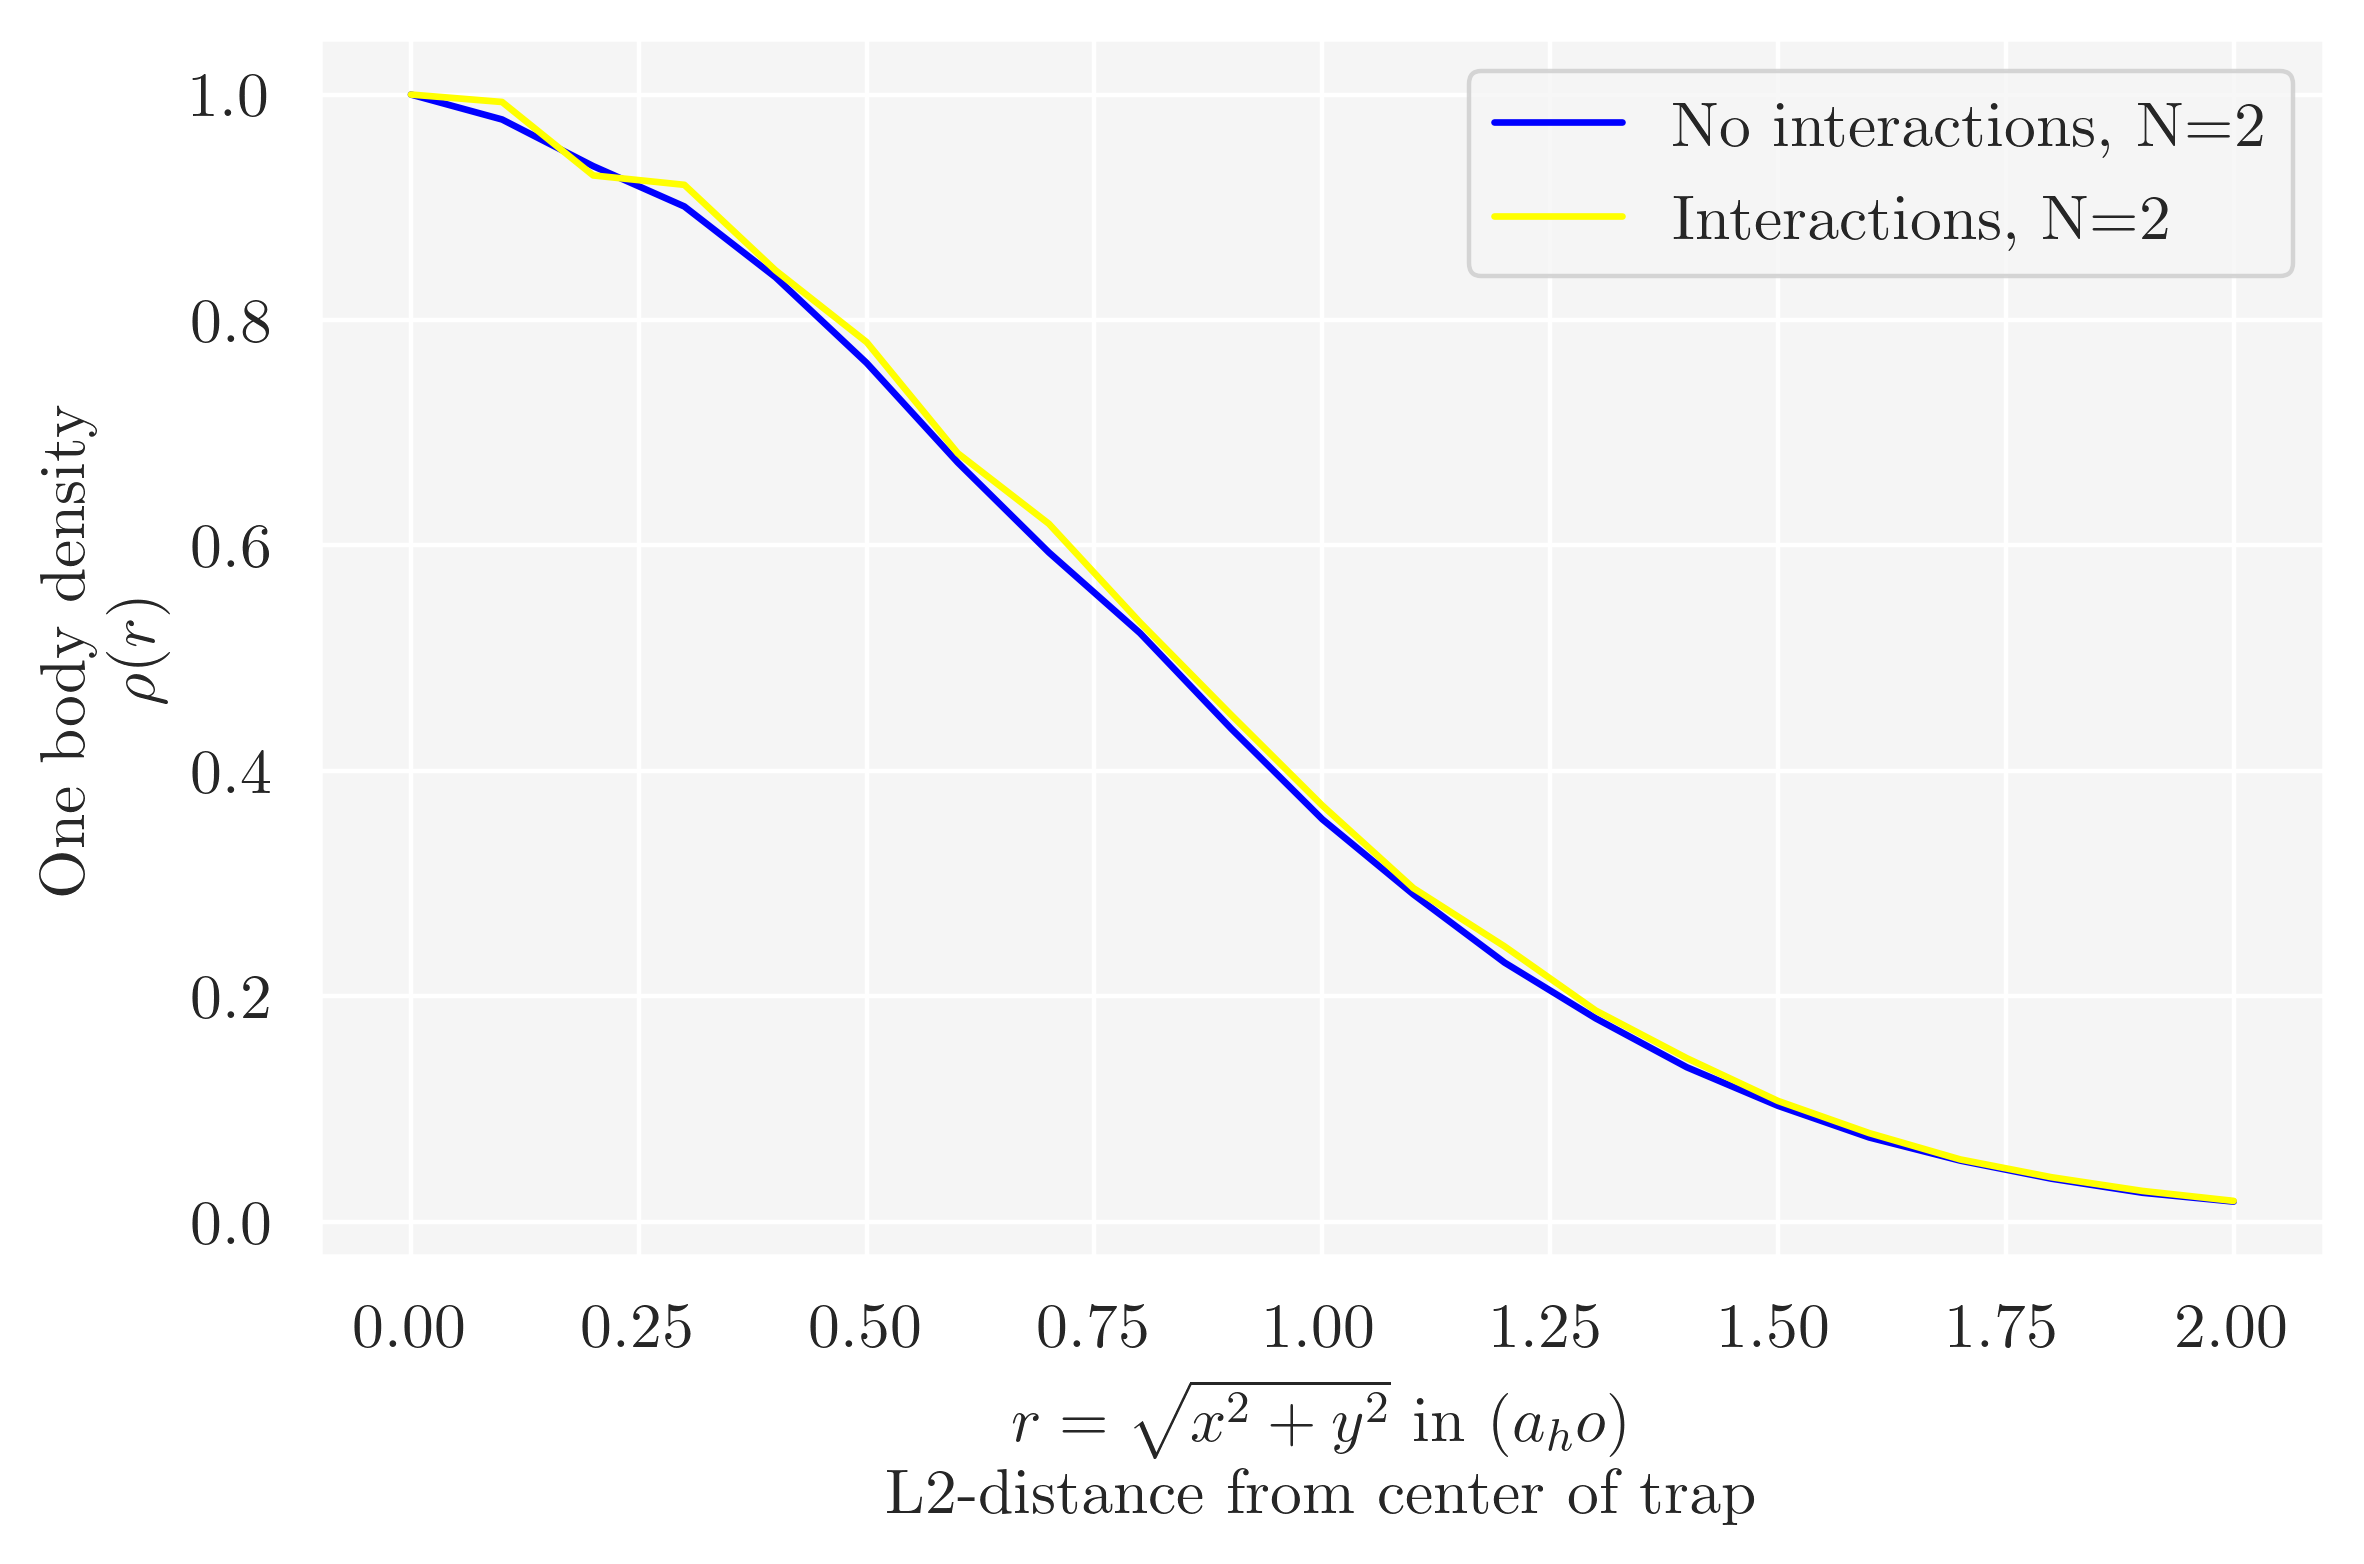

In [40]:
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True, dpi=200)
df_non_interacting["pdf"] = df_non_interacting["pdf"]/max(df_non_interacting["pdf"])
dfN10["pdf"] = dfN10["pdf"]/max(df_non_interacting["pdf"])
sns.lineplot(data=df_non_interacting, x="r", y="pdf", ax=ax, color="blue", label='No interactions, N=2')
sns.lineplot(data=dfN10, x="r", y="pdf", ax=ax, color="yellow", label=r'Interactions, N=2')
tex_xlabel = '\n'.join((r'$r = \sqrt{x^2 + y^2}$ in ($a_ho$)',
                      'L2-distance from center of trap'))
tex_ylabel = '\n'.join(('One body density',
                        r'$\rho(r)$'))
ax.set(xlabel=tex_xlabel, ylabel=tex_ylabel)
ax.legend()
plt.show()

fig.savefig(fig_path("obd_all.pdf"), bbox_inches='tight')

In [12]:
N = 1      # Number of particles
dim = 1      # Dimensionality
omega = 1.   # Oscillator frequency

# Exact energy 
exact_E = exact_energy(N, dim, omega)

# Instantiate wave function
wf = vmc.ASHONIB(N, dim, omega)

# Instantiate sampler
sampler = vmc.samplers.Metropolis(wf)

# Config
nsamples = 10000
alpha_step = 0.05
alphas = np.arange(0.1, 1 + alpha_step, alpha_step)

results = []

start = time.time()
for i, alpha in enumerate(alphas):
    initial_positions = safe_initial_positions_no_interactions(wf, alpha, N, dim)
    result = sampler.sample(nsamples,
                            initial_positions,
                            alpha,
                            nchains=1,
                            scale=1.0,
                            seed=None,
                            warm=True,
                            warmup_iter=500,
                            tune=True,
                            tune_iter=5000,
                            tune_interval=250,
                            tol_tune=1e-5,
                            optimize=False
                           )
    results.append(result)

end = time.time()
print("Sampler elapsed time:", end - start)
print(results)

Warm done
Tune done
Warm after tune done
Sampling energy


NameError: name 'distances' is not defined